In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update('jax_enable_x64', True)
from timeit import timeit
import numpy as np

In [ ]:
@jax.jit # Just-in-time compilation
def f(X, U, d, V):
  return 1 / 2 * jnp.linalg.norm(X - U @ jnp.diag(d) @ V, ord='fro')**2

gradfu = jax.grad(f, argnums=1, has_aux=False)
gradfv = jax.grad(f, argnums=3, has_aux=False)

In [3]:
def gradfu_an(X, U, d, V):
  D = jnp.diag(d)
  return -(X - U @ D @ V) @ V.T @ D


def gradfv_an(X, U, d, V):
  D = jnp.diag(d)
  return -D @ U.T @ (X - U @ D @ V)

In [7]:
def measure(n, k, gradf, gradf_an):
  X = jax.random.normal(jax.random.PRNGKey(0), (n, n))
  U = jax.random.normal(jax.random.PRNGKey(0), (n, k))
  d = jax.random.normal(jax.random.PRNGKey(0), (k,))
  V = jax.random.normal(jax.random.PRNGKey(0), (k, n))
  
  err = jnp.linalg.norm(gradf(X, U, d, V) - gradf_an(X, U, d, V))
  assert err < 1e-7, f'Correctness check failed for n = {n}, k = {k}, err = {err}'

  # Compare speed
  t_grad_an = timeit(lambda: gradf_an(X, U, d, V), number=5)
  
  t_grad = timeit(lambda: gradf(X, U, d, V).block_until_ready(), number=5)

  jit_gradf = jax.jit(gradf)
  t_jit_grad = timeit(lambda: jit_gradf(X, U, d, V).block_until_ready(), number=5)

  return t_grad_an, t_grad, t_jit_grad

Let us measure perfomance of three approaches: analytical, numerical and jitted for the case of $\nabla_U F$

First we will increase $n$ with $k$ fixed at 100. We expect time of analytical approach to increase quadratically with $n$ since the complexity is $O(n^2 k)$. In the log scale, this corresponds to a line with slope 2.

In [25]:
k = 100
t_grad_an = []
t_grad = []
t_jit_grad = []
n_vals = [10, 50, 100, 500, 1000, 2000, 5000, 6000, 7000, 8000]
for n in n_vals:
  times = measure(n, k, gradfu, gradfu_an)
  t_grad_an.append(times[0])
  t_grad.append(times[1])
  t_jit_grad.append(times[2])

In [26]:
import matplotlib.pyplot as plt

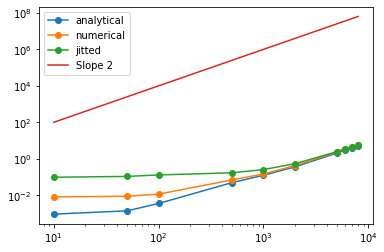

In [27]:
plt.loglog(n_vals, t_grad_an, 'o-', label='analytical')
plt.loglog(n_vals, t_grad, 'o-', label='numerical')
plt.loglog(n_vals, t_jit_grad, 'o-', label='jitted')
plt.plot(n_vals, np.array(n_vals)**2, '-', label='Slope 2')
plt.legend();

We see that at smaller values of $n$ analytical approach works faster than the numerical ones. However, with $n$ increasing, the efficiency of numerical approaches grows. It also can be seen that the elapsed time becomes closer to $O(n^2)$ at larger values of $n$.

Now let us analyze the dependency of time on $k$. The logic is the same but the dependency of time on $k$ is linear $O(n^2 k)$, so in log scale we should expect a line with slope 1.

In [28]:
n = 100
t_grad_an = []
t_grad = []
t_jit_grad = []
k_vals = [10, 50, 100, 500, 1000, 2000, 5000]
for k in k_vals:
  times = measure(n, k, gradfu, gradfu_an)
  t_grad_an.append(times[0])
  t_grad.append(times[1])
  t_jit_grad.append(times[2])

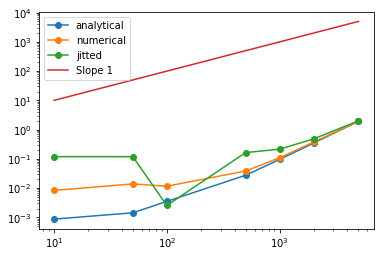

In [29]:
plt.loglog(k_vals, t_grad_an, 'o-', label='analytical')
plt.loglog(k_vals, t_grad, 'o-', label='numerical')
plt.loglog(k_vals, t_jit_grad, 'o-', label='jitted')
plt.plot(k_vals, k_vals, '-', label='Slope 1')
plt.legend();

The dependency becomes close to linear but still not exactly. Probably it could get better at larger values of $k$.

Now we do the same for $\nabla_V F$

In [21]:
k = 100
t_grad_an = []
t_grad = []
t_jit_grad = []
n_vals = [10, 50, 100, 500, 1000, 2000, 5000, 6000, 7000, 8000]
for n in n_vals:
  times = measure(n, k, gradfv, gradfv_an)
  t_grad_an.append(times[0])
  t_grad.append(times[1])
  t_jit_grad.append(times[2])

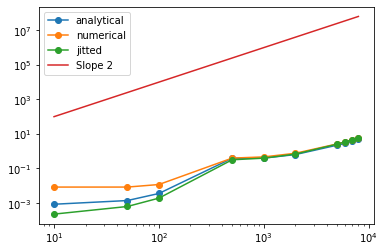

In [24]:
plt.loglog(n_vals, t_grad_an, 'o-', label='analytical')
plt.loglog(n_vals, t_grad, 'o-', label='numerical')
plt.loglog(n_vals, t_jit_grad, 'o-', label='jitted')
plt.plot(n_vals, np.array(n_vals)**2, '-', label='Slope 2')
plt.legend();

In [16]:
n = 100
t_grad_an = []
t_grad = []
t_jit_grad = []
k_vals = [10, 50, 100, 500, 1000, 2000, 5000]
for k in k_vals:
  times = measure(n, k, gradfv, gradfv_an)
  t_grad_an.append(times[0])
  t_grad.append(times[1])
  t_jit_grad.append(times[2])

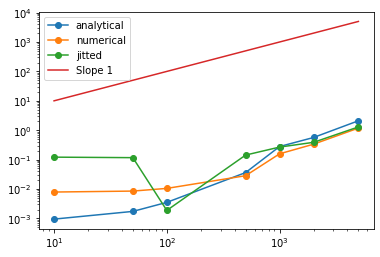

In [18]:
plt.loglog(k_vals, t_grad_an, 'o-', label='analytical')
plt.loglog(k_vals, t_grad, 'o-', label='numerical')
plt.loglog(k_vals, t_jit_grad, 'o-', label='jitted')
plt.plot(k_vals, k_vals, '-', label='Slope 1')
plt.legend();